# Emotion Detection from scratch

**Author:** Shishir Rijal <br>
**Linkedin:** https://www.linkedin.com/in/ShishirRijal/ <br>
**Date created:** 2024/09/14<br>
**Description:** Training an facial emotion detection CNN model from scratch on the Kaggle FER-2013 Dataset.


# Data Set-

Kaggle - https://www.kaggle.com/datasets/msambare/fer2013
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)


# Setting up Kaggle Directory


In [ ]:
!mkdir -p ~/.kaggle/     # Ensure the .kaggle directory exists
!cp kaggle.json ~/.kaggle/  # Copy the kaggle.json file into the directory

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json  # Set correct permissions for the file

In [ ]:
# Download FER-2013 dataset
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 71% 43.0M/60.3M [00:00<00:00, 57.0MB/s]
100% 60.3M/60.3M [00:00<00:00, 72.0MB/s]


In [ ]:
# Unzip the downloaded zip file
!unzip /content/fer2013.zip -d /content/

# Installing Packages


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers, Input
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
    TensorBoard,
    CSVLogger,
)
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Dropout,
    Flatten,
    Dense,
    Activation,
    GlobalAveragePooling2D,
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    load_img,
    img_to_array,
)
from keras.utils import plot_model

# Setting up Directory to save model data.


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
os.makedirs("test_dir", exist_ok=True)

In [ ]:
# Define project name
project_name = "FER_2013_Emotion_Detection"

# List models
model_names = [
    "Custom_CNN_From_Scratch",
    "Custom_CNN_With_Augmentation",
    "VGG16_Transfer_Learning",
    "ResNet50_Transfer_Learning",
]

# Base directory (in this case, Google Colab workspace)
base_dir = "/content/"

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for model in model_names:
    model_dir = os.path.join(project_dir, model)
    os.makedirs(model_dir, exist_ok=True)
    # Example subdirectories for model-related files
    # os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

print(f"Project directory structure created at: {project_dir}")

Project directory structure created at: /content/FER_2013_Emotion_Detection


# Data Cleaning


In [ ]:
# Define the list of acceptable image extensions
image_exts = ["jpeg", "jpg", "png"]

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = "/content/train"

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f"Image not in ext list {file_path}")
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f"Issue with file {file_path}. Error: {e}")
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

# Data Analysis


In [ ]:
for item in os.listdir("/content/train"):
    print(item)

fear
happy
surprise
disgust
angry
neutral
sad


In [ ]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df


# Paths to the training and testing directories.
train_dir = "/content/train"
test_dir = "/content/test"

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, "train")
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, "test")
print(test_count)

       fear  happy  surprise  disgust  angry  neutral   sad
train  4097   7215      3171      436   3995     4965  4830
      fear  happy  surprise  disgust  angry  neutral   sad
test  1024   1774       831      111    958     1233  1247


In [ ]:
sns.set_theme()

<Axes: >

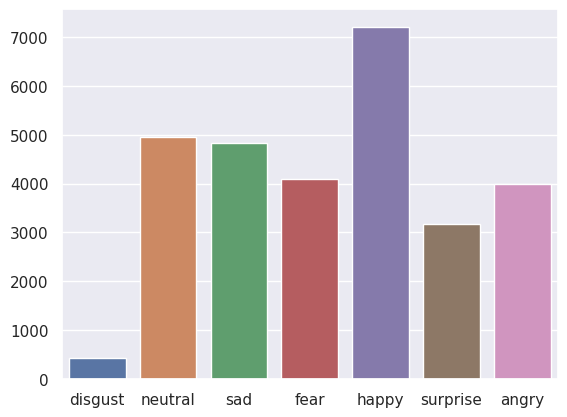

In [ ]:
sns.barplot(data=train_count)

The bar plot shows that there is a huge imbalance in the dataset, with a significantly larger number of images for the "happy" expression and very few for the "disgust" expression. Other expressions are also unevenly distributed. This imbalance means that the model will learn a lot about the "happy" expression but will have minimal information about the "disgust" expression, making it difficult for the model to accurately detect it.


<Axes: >

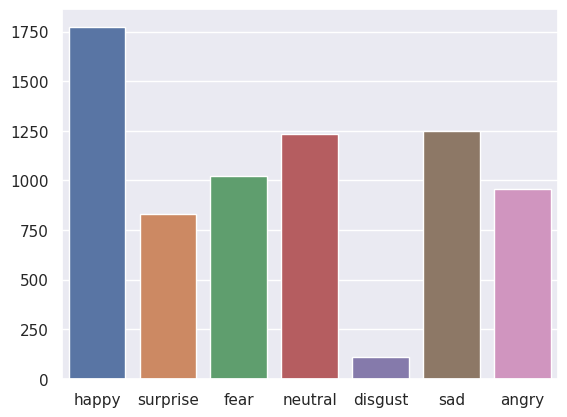

In [ ]:
sns.barplot(test_count)

The images count for each expression follows the same proportion in both the training and testing sets.


# Plotting one image from each emotion.


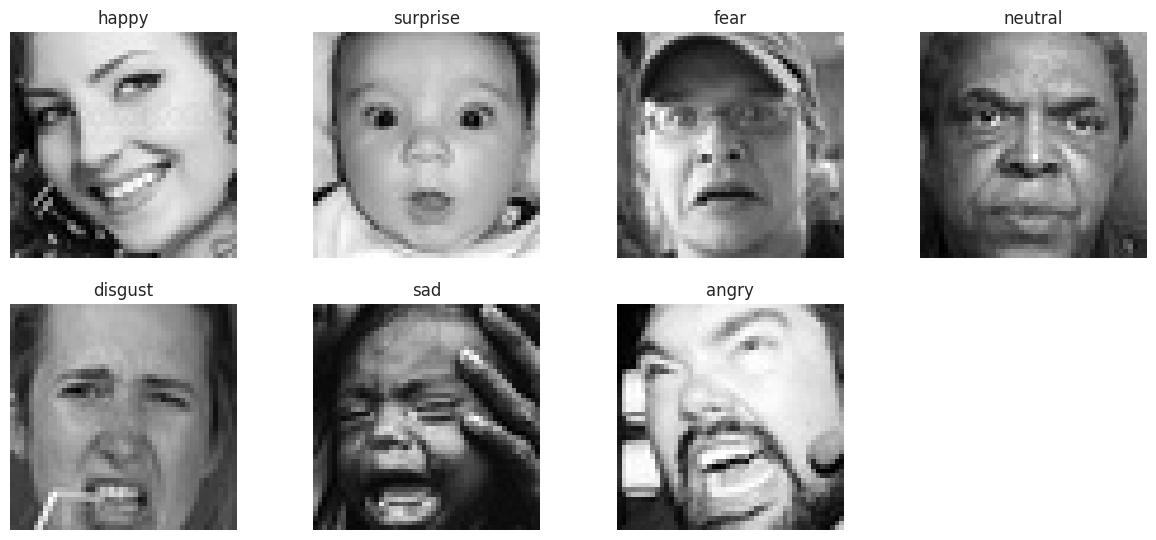

In [ ]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15, 10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[13])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap="gray")
    plt.title(emotion)
    plt.axis("off")

# Plotting random images from given directory


In [ ]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(
            f"Only found {len(image_filenames)} images in {directory_path}, displaying them all."
        )
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"{class_name}")
        axes[i].axis("off")  # Hide the axis
    plt.tight_layout()
    plt.show()

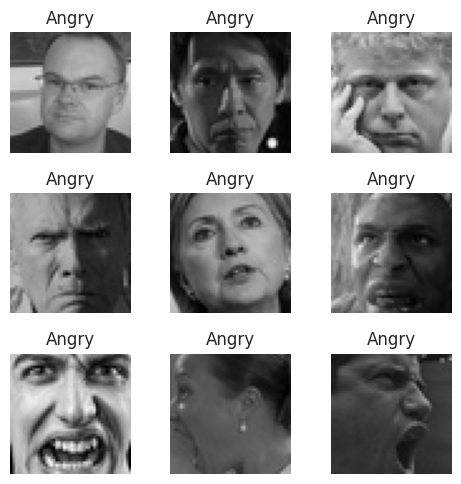

In [ ]:
# Visualizing angry emotion images
angry_directory_path = "/content/train/angry"
plot_images_from_directory(angry_directory_path, class_name="Angry")

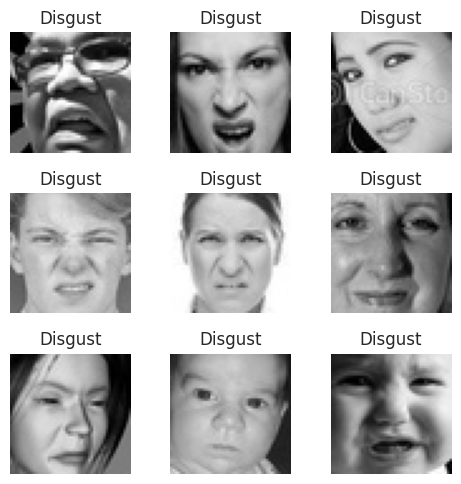

In [ ]:
# Visualizing disgust emotion images
disgust_directory_path = "/content/train/disgust"
plot_images_from_directory(disgust_directory_path, class_name="Disgust")

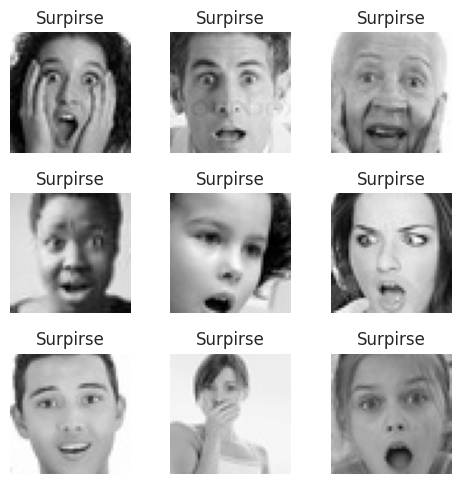

In [ ]:
# Visualizing surprise emotion images
surpirse_directory_path = "/content/train/surprise"
plot_images_from_directory(surpirse_directory_path, class_name="Surpirse")

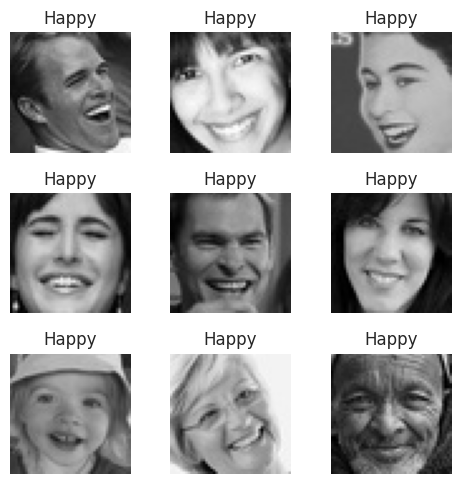

In [ ]:
# Visualizing happy emotion images
disgust_directory_path = "/content/train/happy"
plot_images_from_directory(disgust_directory_path, class_name="Happy")

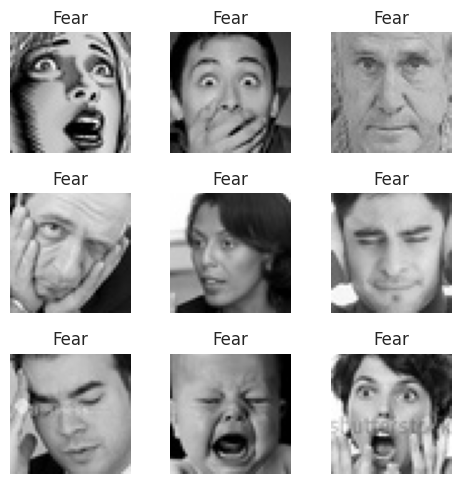

In [ ]:
# Visualizing fear emotion images
surpirse_directory_path = "/content/train/fear"
plot_images_from_directory(surpirse_directory_path, class_name="Fear")

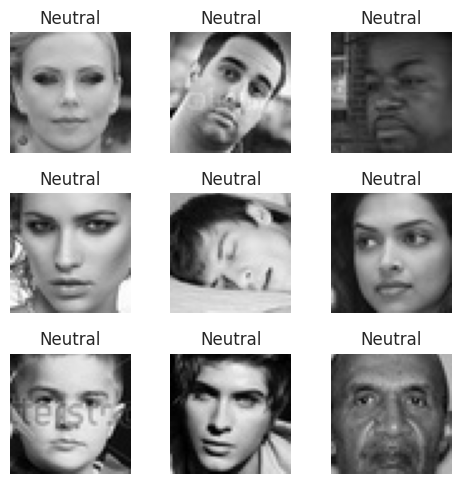

In [ ]:
# Visualizing neutral emotion
surpirse_directory_path = "/content/train/neutral"
plot_images_from_directory(surpirse_directory_path, class_name="Neutral")

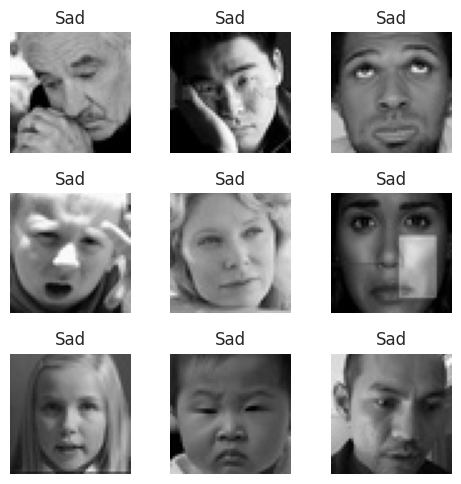

In [ ]:
# Visualizing sad emotion
surpirse_directory_path = "/content/train/sad"
plot_images_from_directory(surpirse_directory_path, class_name="Sad")

# Checking shapes and channels.


In [ ]:
image = "/content/train/angry/Training_10118481.jpg"

img = cv2.imread(image)  # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


Each image in our dataset is 48x48 size and has three channels. It is because cv2 will automatically stack 2 more channels to it and make it 3 channels. Since they are useless will convert it to a single channel image with further processing.


In [ ]:
image_path = "/content/train/angry/Training_10118481.jpg"

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)  # This should now print (48, 48)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


So, the image is now converted to grayscale with only one channel.


# Model 1 : Custom CNN from Scratch


## Initializing the ImageGenerators


In [ ]:
# Define paths to the train and validation directories
train_data_dir = "/content/train"
test_data_dir = "/content/test"

In [ ]:
# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7

In [ ]:
# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
    subset="training",
)

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
    subset="validation",
)

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
)
# subset='validation')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

# Accessing class labels for the validation data
test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(
    Conv2D(
        32,
        kernel_size=(3, 3),
        kernel_initializer="glorot_uniform",
        padding="same",
        input_shape=(img_width, img_height, 1),
    )
)
model.add(Activation("relu"))
model.add(Conv2D(64, kernel_size=(3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(
    Conv2D(
        128,
        kernel_size=(3, 3),
        padding="same",
        kernel_regularizer=regularizers.l2(0.01),
    )
)
model.add(Activation("relu"))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(
    Conv2D(
        512,
        kernel_size=(3, 3),
        padding="same",
        kernel_regularizer=regularizers.l2(0.01),
    )
)
model.add(Activation("relu"))
model.add(
    Conv2D(
        512,
        kernel_size=(3, 3),
        padding="same",
        kernel_regularizer=regularizers.l2(0.01),
    )
)
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes))
model.add(Activation("softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 11, 11, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 512)           │              

 Total params: 17,046,535 (65.03 MB)

 Trainable params: 17,044,871 (65.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [ ]:
# Compiling the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 11, 11, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 512)           │              

 Total params: 17,046,535 (65.03 MB)

 Trainable params: 17,044,871 (65.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

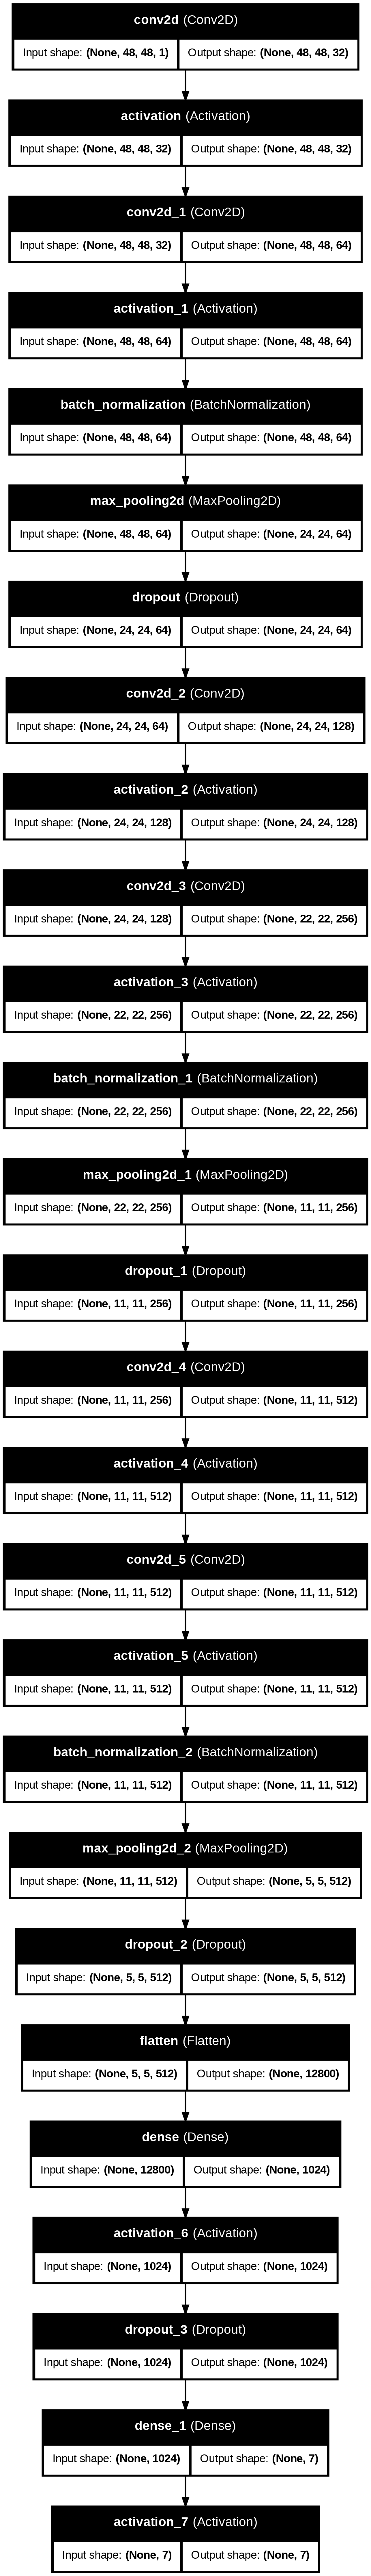

In [ ]:
plot_model(
    model,
    to_file="/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png",
    show_shapes=True,
    show_layer_names=True,
)

# Understanding Callbacks


In [ ]:
# File path for the model checkpoint
cnn_path = "/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch"
name = "Custom_CNN_model.keras"
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [ ]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(
    filepath=chk_path, save_best_only=True, verbose=1, mode="min", monitor="val_loss"
)

In [ ]:
# Callback for early stopping
earlystop = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3, verbose=1, restore_best_weights=True
)

In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=6, verbose=1, min_delta=0.0001
)

In [ ]:
# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path, "training.log"))

In [ ]:
# Aggregating all callbacks into a list
callbacks = [
    checkpoint,
    earlystop,
    reduce_lr,
    csv_logger,
]  # Adjusted as per your use-case

# Calculating Steps for epoch


In [ ]:
train_generator.samples

22968

In [ ]:
train_steps_per_epoch = int(
    np.ceil(train_generator.samples / train_generator.batch_size)
)
validation_steps_epoch = int(
    np.ceil(validation_generator.samples / validation_generator.batch_size)
)
test_steps_per_epoch = int(np.ceil(test_generator.samples / test_generator.batch_size))

In [ ]:
print(train_steps_per_epoch)
print(validation_steps_epoch)
print(test_steps_per_epoch)

359
90
113


# Model Training


In [ ]:
history = model.fit(
    train_generator,
    # steps_per_epoch=train_steps_per_epoch,
    epochs=60,
    validation_data=validation_generator,
    # validation_steps=validation_steps_epoch,
    callbacks=callbacks,
)

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2380 - loss: 13.3177
Epoch 1: val_loss improved from inf to 14.53587, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 54s 110ms/step - accuracy: 0.2381 - loss: 13.3152 - val_accuracy: 0.0343 - val_loss: 14.5359 - learning_rate: 1.0000e-04
Epoch 2/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3460 - loss: 10.7651
Epoch 2: val_loss improved from 14.53587 to 9.45455, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 54s 64ms/step - accuracy: 0.3461 - loss: 10.7637 - val_accuracy: 0.3870 - val_loss: 9.4546 - learning_rate: 1.0000e-04
Epoch 3/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3859 - loss: 8.7298
Epoch 3: val_loss improved from 9.45455 to 7.58997, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras

As we can see from above results, the model began training with an initial accuracy of 23.8% and a high loss of 13.31.

Over the course of several epochs, there was a noticeable improvement in performance. By the **18th epoch**, the training accuracy had increased to 78.6% with a corresponding validation accuracy of 60.5%. The validation loss showed a significant reduction, improving from 14.53 in the first epoch to 1.52 by the 18th epoch.

Although the model continued training for 21 epochs, the best performance was recorded at epoch 18, after which the validation loss plateaued and early stopping was triggered. This indicates that the model achieved optimal performance at epoch 18, preventing overfitting in the subsequent epochs.


# Plotting Performance Metrics


In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")

    plt.show()

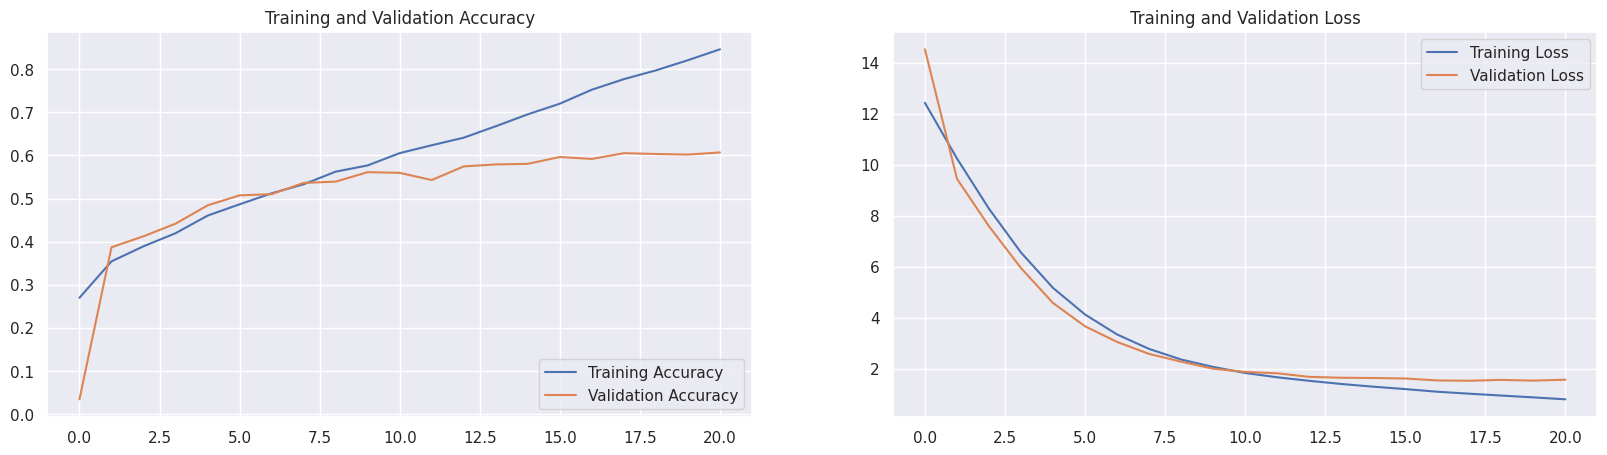

In [ ]:
plot_training_history(history)

# Model Evaluation


In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print(
    "final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(
        train_accu * 100, test_accu * 100
    )
)

359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.8830 - loss: 0.8122
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6129 - loss: 1.4766
final train accuracy = 88.36 , validation accuracy = 60.87


After evaluating the model, the final **training accuracy was 88.36%**, with a corresponding loss of 0.81.

For the validation data, the model achieved an accuracy of 60.87% and a loss of 1.48.

This indicates that while the model performed well on the training data, there was a noticeable gap between training and validation accuracy, suggesting some overfitting or potential challenges with generalizing to unseen data.


# Plotting Confusion Matrix


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


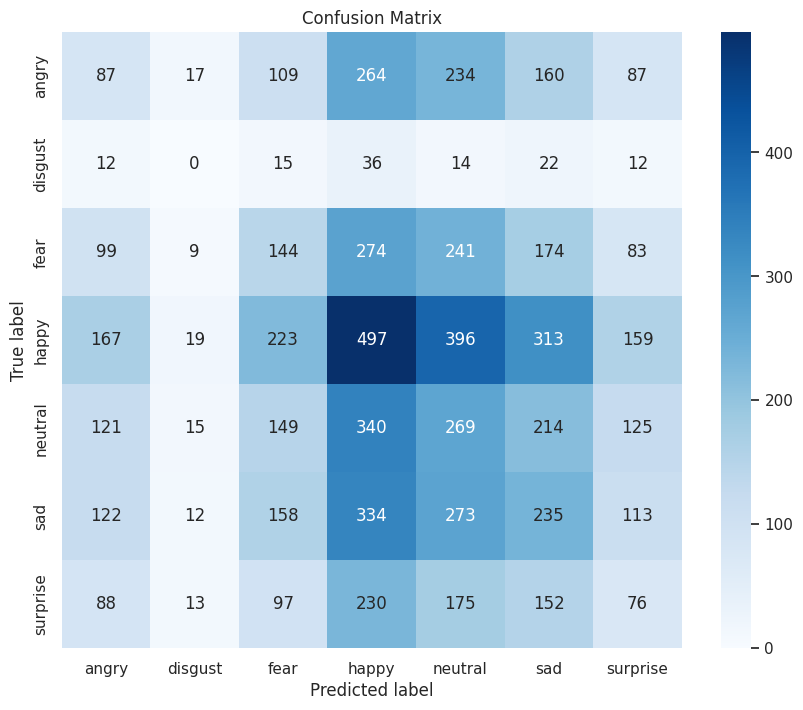

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(
    model.predict(
        test_generator,
        steps=int(np.ceil(test_generator.samples / test_generator.batch_size)),
    ),
    axis=1,
)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
)
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

From the above confusion matrix we can see that the model struggles most with the "disgust" class, which has very few correct predictions (just 0 correctly predicted), while emotions like "happy" and "neutral" are predicted with more accuracy (497 and 340 correct predictions, respectively).
So, we can say that the model is barely performing well..


In [ ]:
# Printing the classification report
report = classification_report(
    true_classes, predicted_classes, target_names=class_labels
)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.12      0.09      0.11       958
     disgust       0.00      0.00      0.00       111
        fear       0.16      0.14      0.15      1024
       happy       0.25      0.28      0.27      1774
     neutral       0.17      0.22      0.19      1233
         sad       0.19      0.19      0.19      1247
    surprise       0.12      0.09      0.10       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.18      0.18      0.18      7178



**Overall Accuracy:** The model achieved an accuracy of 18%, indicating that it correctly classified 18% of the total 7,178 samples. This shows the model is struggling with classification, with performance barely better than random guessing.

**Precision:** Indicates how many of the predicted labels were correct. The precision across all emotions is low, with the highest precision for the "happy" class at 0.25, and the lowest for "disgust" at 0.00.

**Recall:** Measures how many actual instances of a class were correctly predicted. The highest recall is again for the "happy" class at 0.28, but very low for "disgust" (0.00), meaning the model almost never predicts "disgust" correctly.

**F1-score:** The harmonic mean of precision and recall. The best F1-score is for the "happy" class (0.27), while the worst is for "disgust" (0.00).


# Making Predictions


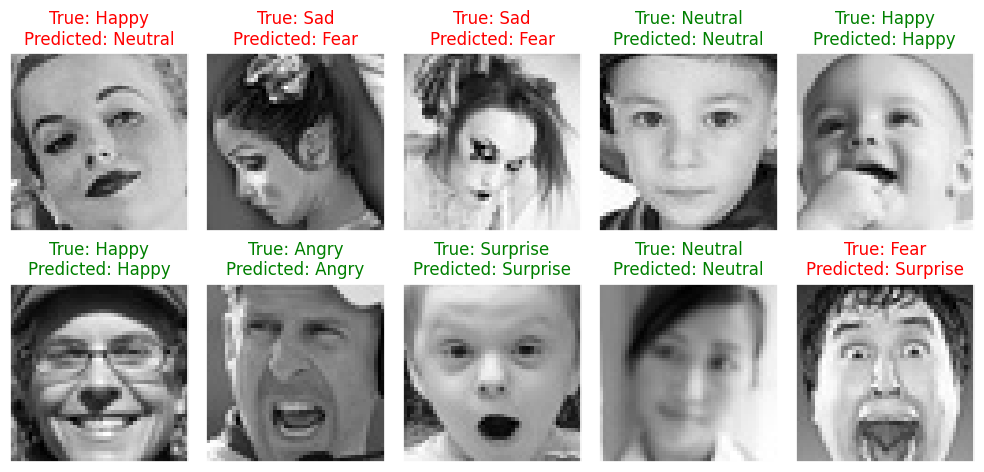

In [ ]:
# Emotion classes for the dataset
Emotion_Classes = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(
    nrows=2, ncols=5, figsize=(10, 5), subplot_kw={"xticks": [], "yticks": []}
)

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(
        test_generator[Random_batch][1][Random_Img_Index[i]], axis=0
    )

    # Making a prediction using the model
    Model_Prediction = np.argmax(
        model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1
    )[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap="gray")  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = (
        "green"
        if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]
        else "red"
    )
    ax.set_title(
        f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}",
        color=color,
    )

plt.tight_layout()
plt.show()

As clearly seen from above results, our model is not performing good at all.


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

model.save("/content/drive/MyDrive/custom_cnn_model.keras")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Model 2: Image Augmentation


Our above model didn't perform well at all.

It may be because we have very less data than what's required to train the deep learning CNN model.

So, let's take a new appraoch where we'll train the same CNN model as above, but this time we'll perform image augmentation so that we can increase the size of our dataset for training.


In [ ]:
# Define paths to the train and validation directories
train_data_dir = "/content/train"
test_data_dir = "/content/test"
# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes


# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1.0 / 255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode="nearest",  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2,  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1.0 / 255)


# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
    subset="training",
)

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
    subset="validation",
)

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


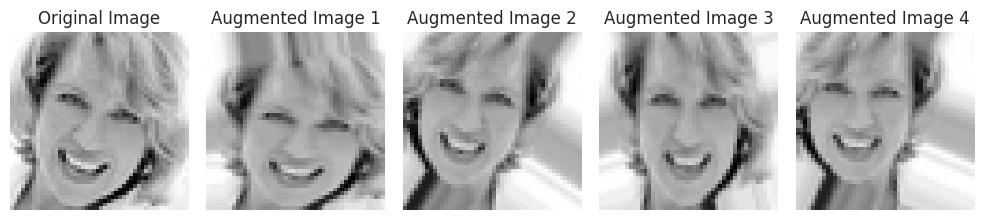

In [ ]:
# Path to your specific image
image_path = "/content/train/happy/Training_10080933.jpg"

# Load and convert the image to an array
img = load_img(
    image_path, color_mode="grayscale", target_size=(img_width, img_height)
)  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape(
    (1,) + img_array.shape
)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap="gray")
    ax.set_title(f"Augmented Image {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Same CNN Model as above


In [ ]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

# Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(
    Conv2D(
        32, kernel_size=(3, 3), padding="same", input_shape=(img_width, img_height, 1)
    )
)
model.add(tf.keras.layers.Activation("relu"))
model.add(Conv2D(64, kernel_size=(3, 3), padding="same"))
model.add(tf.keras.layers.Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(
    Conv2D(
        128,
        kernel_size=(3, 3),
        padding="same",
        kernel_regularizer=regularizers.l2(0.01),
    )
)
model.add(tf.keras.layers.Activation("relu"))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(
    Conv2D(
        512,
        kernel_size=(3, 3),
        padding="same",
        kernel_regularizer=regularizers.l2(0.01),
    )
)
model.add(tf.keras.layers.Activation("relu"))
model.add(
    Conv2D(
        512,
        kernel_size=(3, 3),
        padding="same",
        kernel_regularizer=regularizers.l2(0.01),
    )
)
model.add(tf.keras.layers.Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation("softmax"))

# Compiling the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


# File path for the model checkpoint
cnn_path = "/content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation"
name = "Custom_CNN_augmented_model.keras"
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(
    filepath=chk_path, save_best_only=True, verbose=1, mode="min", monitor="val_loss"
)

# Callback for early stopping
earlystop = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3, verbose=1, restore_best_weights=True
)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=6, verbose=1, min_delta=0.0001
)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path, "training.log"))

# Aggregating all callbacks into a list
callbacks = [
    checkpoint,
    earlystop,
    reduce_lr,
    csv_logger,
]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = (
    validation_generator.samples // validation_generator.batch_size + 1
)
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    # steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    # validation_steps=validation_steps_epoch,
    callbacks=callbacks,
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2067 - loss: 13.4110
Epoch 1: val_loss improved from inf to 12.41910, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - accuracy: 0.2067 - loss: 13.4085 - val_accuracy: 0.2278 - val_loss: 12.4191 - learning_rate: 1.0000e-04
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2395 - loss: 10.8197
Epoch 2: val_loss improved from 12.41910 to 9.98372, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.2395 - loss: 10.8182 - val_accuracy: 0.2604 - val_loss: 9.9837 - learning_rate: 1.0000e-04
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2391 - loss: 8.6764
Epoch 3: val_loss improved from 9.98372 to 7.41094, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_Wit

The findings from the current model using augmentation demonstrate significant improvements over the previous iteration. Accuracy increased steadily from 20.67% at Epoch 1 to 55.38% by Epoch 24, indicating effective learning.

Validation accuracy also improved, reaching 54.29% before showing slight declines, which suggests some overfitting. Training loss decreased dramatically from 13.41 to 1.35, while validation loss improved from 12.42 to 1.37. The constant learning rate of 1e-4 contributed to consistent progress without drastic fluctuations.

Compared to the previous model, this version achieved faster accuracy gains and reduced validation loss more efficiently. By Epoch 10, the new model had reached 34.44% accuracy, outpacing the earlier model’s performance at a similar stage. Overall, the current model not only surpassed the previous one in final accuracy but also **managed overfitting more effectively**, though there is still a need for potential regularization or early stopping to maintain validation performance.


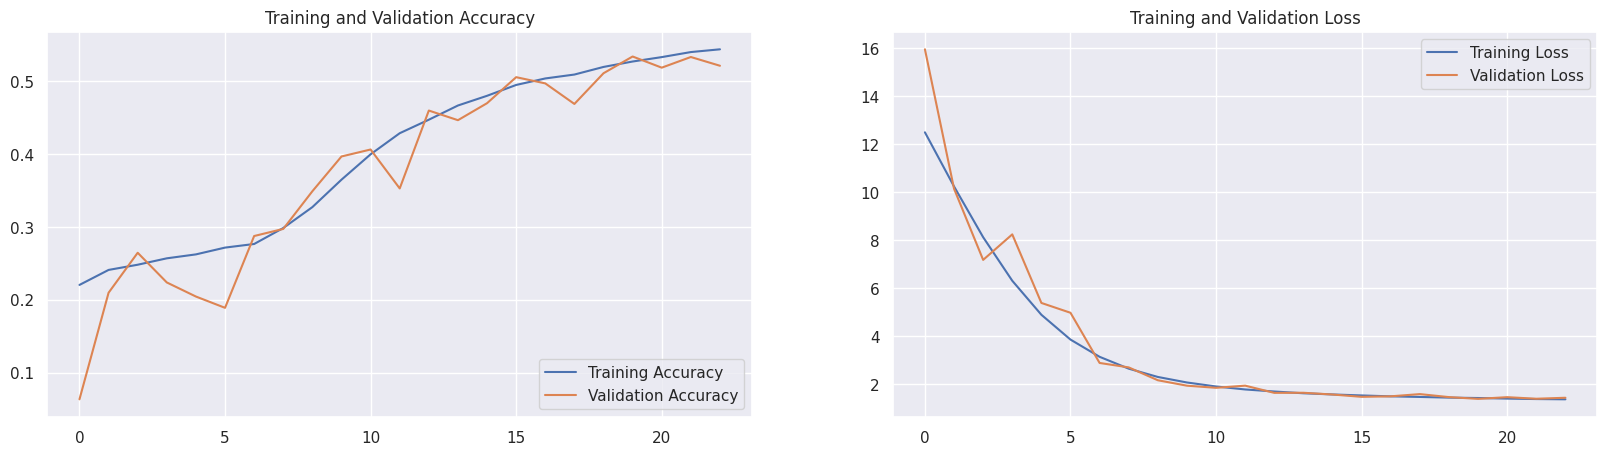

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print(
    "final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(
        train_accu * 100, test_accu * 100
    )
)

InvalidArgumentError: Graph execution error:

Detected at node convolution defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-59-b66160495bb6>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 429, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 82, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 209, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 556, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 243, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 233, in convolution_op

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 909, in conv

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 254, in conv

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 244, in _conv_xla

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 231, in _conv

Depth of output must be a multiple of the number of groups: 32 vs 3

Stack trace for op definition: 
File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "<ipython-input-59-b66160495bb6>", line 1, in <cell line: 1>
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 429, in evaluate
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 82, in test_step
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 209, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 556, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 243, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 233, in convolution_op
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 909, in conv
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 254, in conv
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 244, in _conv_xla
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 231, in _conv

	 [[{{node convolution}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_261331[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_261400]

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(
    model.predict(
        test_generator,
        steps=np.ceil(test_generator.samples / test_generator.batch_size),
    ),
    axis=1,
)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
)
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(
    true_classes, predicted_classes, target_names=class_labels, zero_division=0
)
print("Classification Report:\n", report)

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

model.save("/content/drive/MyDrive/custom_cnn_model_with_augmentation.keras")

# Model 3: Transfer Learning VGGNET


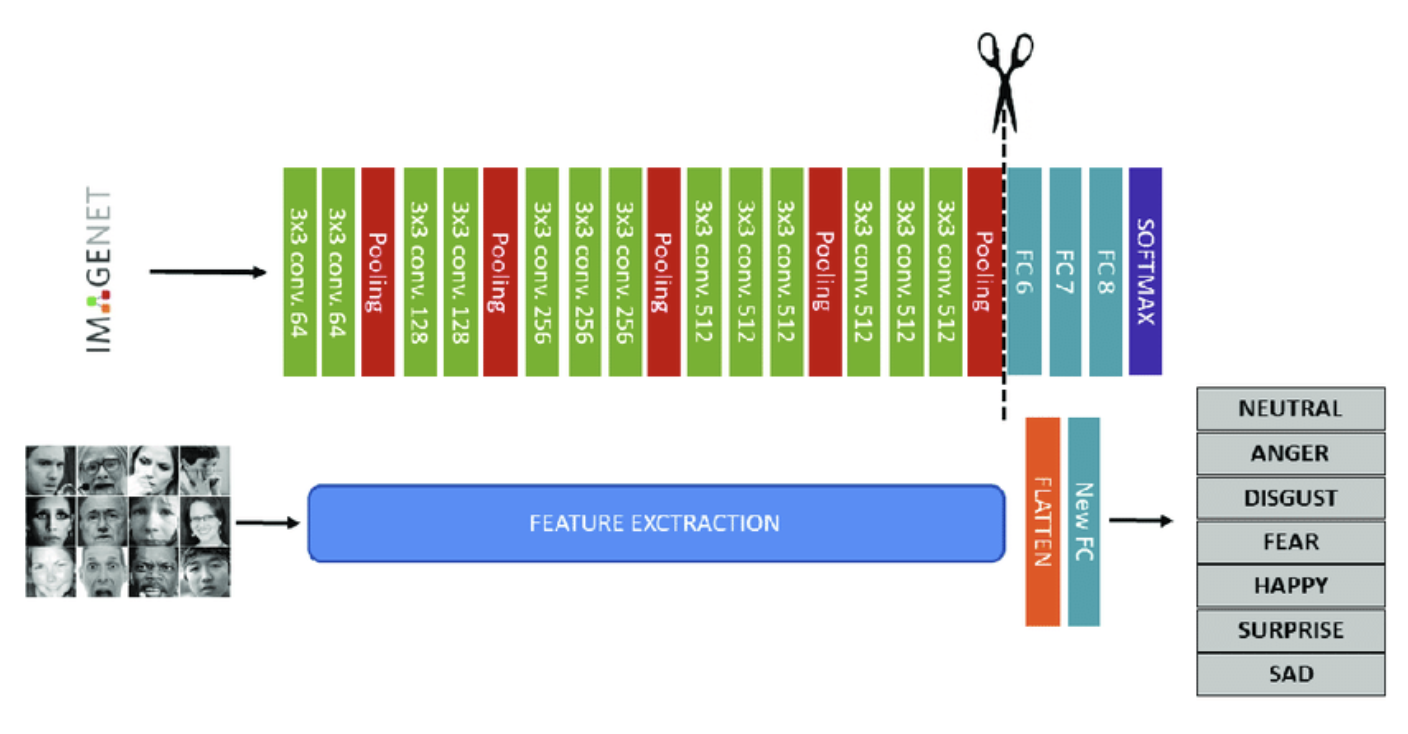


In [ ]:
# Define paths to the train and validation directories
train_data_dir = "/content/train"
test_data_dir = "/content/test"

# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 224, 224  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
    # validation_split=0.2
)

test_preprocessor = ImageDataGenerator(
    rescale=1 / 255.0,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
    subset="training",
    shuffle=True,
)

test_generator = test_preprocessor.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
)
# subset='validation')

In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight="balanced",  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes,  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

In [ ]:
classes = 7

# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
vgg.summary()

In [ ]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

In [ ]:
classes

In [ ]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation="relu", kernel_initializer="he_normal")(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation="relu", kernel_initializer="he_normal")(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(7, activation="softmax", kernel_initializer="he_normal")(x)

# Creating the model
model = Model(inputs=vgg.input, outputs=output)

# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False
    ),
    metrics=["accuracy"],
)

# Model summary to see all layers
model.summary()

In [ ]:
# File path for the model checkpoint
cnn_path = "/content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning"
name = "VGG16_Transfer_Learning.keras"
# chk_path = os.path.join(cnn_path, name)
chk_path = "/content/drive/MyDrive/FER_2013_Emotion_Detection/Checkpoints/vgg16_transferlearning_model.keras"

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(
    filepath=chk_path, save_best_only=True, verbose=1, mode="min", monitor="val_loss"
)

# Callback for early stopping
earlystop = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3, verbose=1, restore_best_weights=True
)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=6, verbose=1, min_delta=0.0001
)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path, "training.log"))

# Aggregating all callbacks into a list
callbacks = [
    checkpoint,
    earlystop,
    reduce_lr,
    csv_logger,
]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(
    train_generator,
    # steps_per_epoch=train_steps_per_epoch,
    epochs=70,
    validation_data=test_generator,
    # validation_steps=test_steps_epoch,
    class_weight=class_weights_dict,
    callbacks=callbacks,
)

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print(
    "final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(
        train_accu * 100, test_accu * 100
    )
)

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(
    model.predict(
        test_generator,
        steps=np.ceil(test_generator.samples / test_generator.batch_size),
    ),
    axis=1,
)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
)
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(
    true_classes, predicted_classes, target_names=class_labels, zero_division=0
)
print("Classification Report:\n", report)

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

model.save("/content/drive/MyDrive/vgg16_transferlearning_model.keras")

# Model 4 : Transfer Leanring - ResNet50


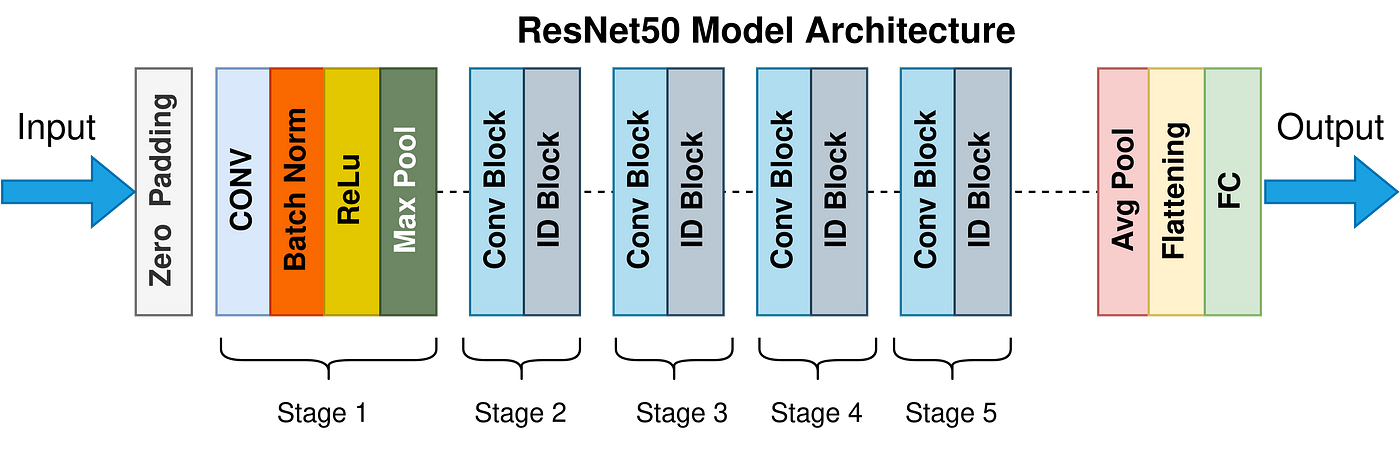


In [ ]:
# Directory paths for training and testing data
train_dir = "/content/train"
test_dir = "/content/test"

# Batch size for data generators
batch_size = 64

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(
    rescale=1 / 255.0,  # Rescale pixel values to [0,1]
    rotation_range=10,  # Random rotation within range [-10,10] degrees
    zoom_range=0.2,  # Random zoom between [0.8, 1.2]
    width_shift_range=0.1,  # Random horizontal shift within range [-0.1, 0.1]
    height_shift_range=0.1,  # Random vertical shift within range [-0.1, 0.1]
    horizontal_flip=True,  # Random horizontal flip
    fill_mode="nearest",  # Fill mode for handling newly created pixels
)

# Configuration for testing data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1 / 255.0)  # Rescale pixel values to [0,1]

# Data generators for training and testing data
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Directory containing training data
    class_mode="categorical",  # Classification mode for categorical labels
    target_size=(224, 224),  # Resize input images to (224,224)
    color_mode="rgb",  # Color mode for images (RGB)
    shuffle=True,  # Shuffle training data
    batch_size=batch_size,  # Batch size for training
    subset="training",  # Subset of data (training)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,  # Directory containing testing data
    class_mode="categorical",  # Classification mode for categorical labels
    target_size=(224, 224),  # Resize input images to (224,224)
    color_mode="rgb",  # Color mode for images (RGB)
    shuffle=False,  # Do not shuffle testing data
    batch_size=batch_size,  # Batch size for testing
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Introducing Class wieghts for imbalanced data


In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight="balanced",  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes,  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
ResNet50V2 = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3), include_top=False, weights="imagenet"
)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [ ]:
def Create_ResNet50V2_Model():
    inputs = Input(shape=(224, 224, 3))  # Define input shape explicitly
    x = ResNet50V2(inputs)  # Pass inputs to ResNet50V2
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(64, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(7, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)  # Create the model
    return model

In [ ]:
model = Create_ResNet50V2_Model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,422,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,996,295 (114.43 MB)

 Trainable params: 22,779,527 (86.90 MB)

 Non-trainable params: 7,216,768 (27.53 MB)

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# File path for the model checkpoint
cnn_path = "/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning"
name = "ResNet50_Transfer_Learning.keras"
# chk_path = os.path.join(cnn_path, name)
chk_path = "/content/drive/MyDrive/FER_2013_Emotion_Detection/Checkpoints/ResNet50_Transfer_Learning.keras"


# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(
    filepath=chk_path, save_best_only=True, verbose=1, mode="min", monitor="val_loss"
)

# Callback for early stopping
earlystop = EarlyStopping(
    monitor="val_accuracy", patience=7, restore_best_weights=True, verbose=1
)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=2,
    #                             min_lr=0.00005,
    verbose=1,
)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path, "training.log"))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
train_history = model.fit(
    train_generator,
    # steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=test_generator,
    # validation_steps=test_steps_epoch,
    class_weight=class_weights_dict,
    callbacks=callbacks,
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.2673 - loss: 2.1241
Epoch 1: val_loss improved from inf to 4.59307, saving model to /content/drive/MyDrive/FER_2013_Emotion_Detection/Checkpoints/ResNet50_Transfer_Learning.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 456s 924ms/step - accuracy: 0.2674 - loss: 2.1237 - val_accuracy: 0.4097 - val_loss: 4.5931
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.4104 - loss: 1.6423
Epoch 2: val_loss improved from 4.59307 to 1.44312, saving model to /content/drive/MyDrive/FER_2013_Emotion_Detection/Checkpoints/ResNet50_Transfer_Learning.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 388s 849ms/step - accuracy: 0.4104 - loss: 1.6422 - val_accuracy: 0.4645 - val_loss: 1.4431
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.4726 - loss: 1.4639
Epoch 3: val_loss improved from 1.44312 to 1.24111, saving model to /content/drive/MyDrive/FER_2013_Emotion_Detection/Checkpoints/ResNet50_Transfer_Learning.keras
449/449 ━━━━━━━━━━

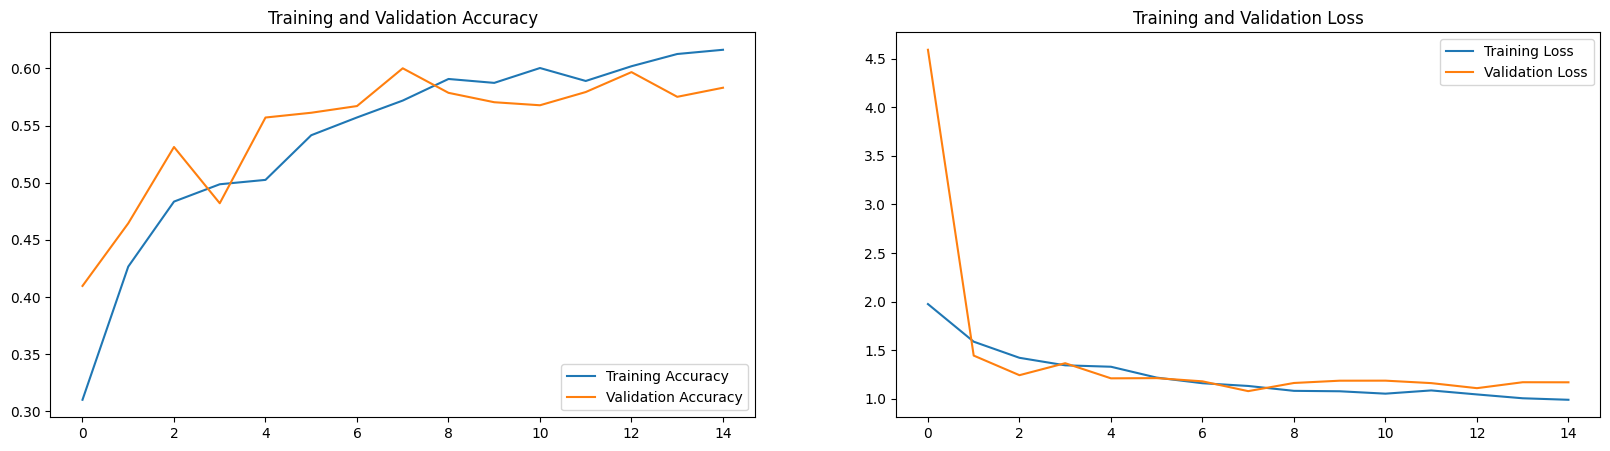

In [ ]:
plot_training_history(train_history)

In [ ]:
import keras

In [ ]:
# model = keras.saving.load_model("/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras")

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print(
    "final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(
        train_accu * 100, test_accu * 100
    )
)

449/449 ━━━━━━━━━━━━━━━━━━━━ 4841s 11s/step - accuracy: 0.6023 - loss: 1.0551
113/113 ━━━━━━━━━━━━━━━━━━━━ 1121s 10s/step - accuracy: 0.5509 - loss: 1.1723
final train accuracy = 60.18 , validation accuracy = 60.00


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 1156s 10s/step


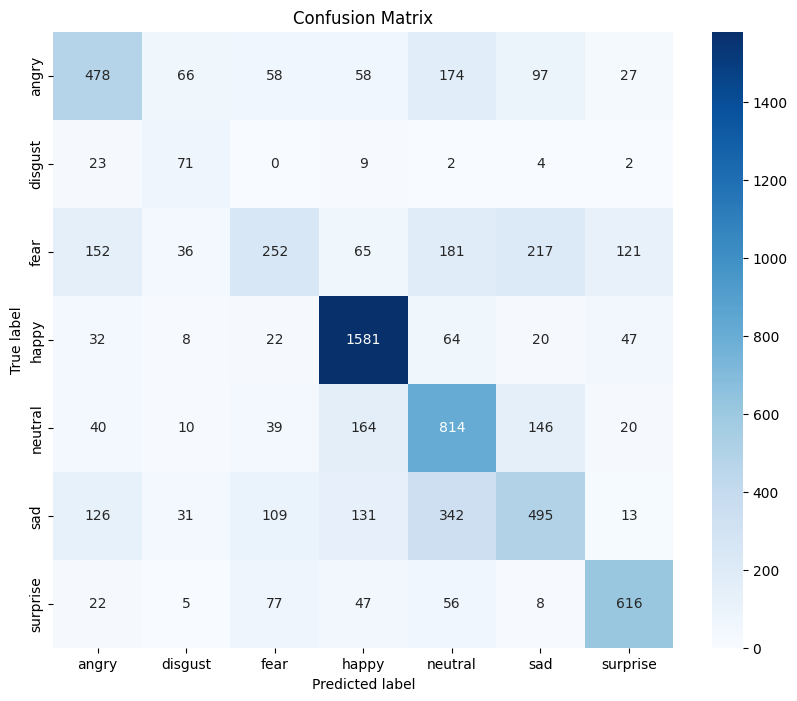

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(
    model.predict(
        test_generator,
        steps=int(np.ceil(test_generator.samples / test_generator.batch_size)),
    ),
    axis=1,
)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
)
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(
    true_classes, predicted_classes, target_names=class_labels, zero_division=0
)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.55      0.50      0.52       958
     disgust       0.31      0.64      0.42       111
        fear       0.45      0.25      0.32      1024
       happy       0.77      0.89      0.83      1774
     neutral       0.50      0.66      0.57      1233
         sad       0.50      0.40      0.44      1247
    surprise       0.73      0.74      0.73       831

    accuracy                           0.60      7178
   macro avg       0.54      0.58      0.55      7178
weighted avg       0.59      0.60      0.59      7178



# AUC ROC plot for each class


In [ ]:
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes = list(test_generator.class_indices.keys())

113/113 ━━━━━━━━━━━━━━━━━━━━ 1140s 10s/step


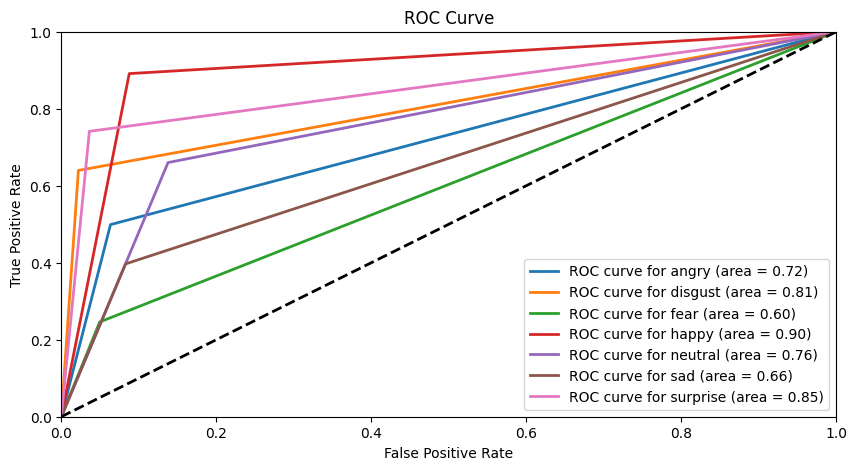

In [ ]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:, i], preds_encoded[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 5))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2"]
for i, color in enumerate(colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})",
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

In [ ]:
model.save("Resnet_model_version_2.keras")

In [ ]:
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/FER_2013_Emotion_Detection/Checkpoints/ResNet50_Transfer_Learning.keras"
)

In [ ]:
# model.summary()

# Push all your models into Drive for easy access.


In [ ]:
!cp /content/FER_2013_Emotion_Detection /content/drive/MyDrive/

## If you are here and followed and learned everything, you are in a great positon to build a project at a industry standard level. Kudos to you!!

## All that's left is Deployement


In [ ]:
model =

# Deployement


# Gradio


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip3 install gradio

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import gradio as gr
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.preprocessing import image

In [ ]:
# Ensure your model is loaded here
# model = ... # Load your trained model
# Load your pre-trained model
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/Emotion_Detection/Final_Resnet50_Best_model.keras"
)

In [ ]:
# Emotion labels dictionary
emotion_labels = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "surprise": 6,
}
index_to_emotion = {v: k for k, v in emotion_labels.items()}
index_to_emotion

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [ ]:
def prepare_image(img_pil):
    """Preprocess the PIL image to fit your model's input requirements."""
    # Convert the PIL image to a numpy array with the target size
    img = img_pil.resize((224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Convert single image to a batch.
    img_array /= 255.0  # Rescale pixel values to [0,1], as done during training
    return img_array


# Define the Gradio interface
def predict_emotion(image):
    # Preprocess the image
    processed_image = prepare_image(image)
    # Make prediction using the model
    prediction = model.predict(processed_image)
    # Get the emotion label with the highest probability
    predicted_class = np.argmax(prediction, axis=1)
    predicted_emotion = index_to_emotion.get(predicted_class[0], "Unknown Emotion")
    return predicted_emotion


interface = gr.Interface(
    fn=predict_emotion,  # Your prediction function
    inputs=gr.Image(
        type="pil"
    ),  # Input for uploading an image, directly compatible with PIL images
    outputs="text",  # Output as text displaying the predicted emotion
    title="Emotion Detection",
    description="Upload an image and see the predicted emotion.",
)

# Launch the Gradio interface
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://eb53f8c30e2eca7f49.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
